Credits to https://keras.io/guides/transfer_learning/

# Imports

In [1]:
# import tensorflow_datasets as tfds
from keras.utils import image_dataset_from_directory, split_dataset
from matplotlib import pyplot as plt
from keras.layers import RandomFlip, RandomRotation
from tensorflow import data as tf_data
from  keras.applications import Xception
from keras import Input
from keras.layers import Rescaling
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dropout
import numpy as np
seed = 4512
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.warn_explicit = ignore_warn


# Load data from local folder
You need to load and expand data from  https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip

After downloading follow these steps:
* Expand data to Folder studientage-ml/data/cats_dogs
* create two folders "cats" and "dogs":
* studientage-ml/data/cats_dogs/cats
* studientage-ml/data/cats_dogs/dogs
* move all cats<no>.jpg images to the "cats" folder and all dogs<no>.jpg images to the "dogs" folde

In [2]:
# Load data; 80% training; 20% for validation and test (see below)
train_ds, test = image_dataset_from_directory(
    "../data/cats_dogs",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=(150, 150),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


In [3]:
# make sure we have 10% validation and 10% test data
validation_ds, test_ds = split_dataset(test, left_size=0.5)

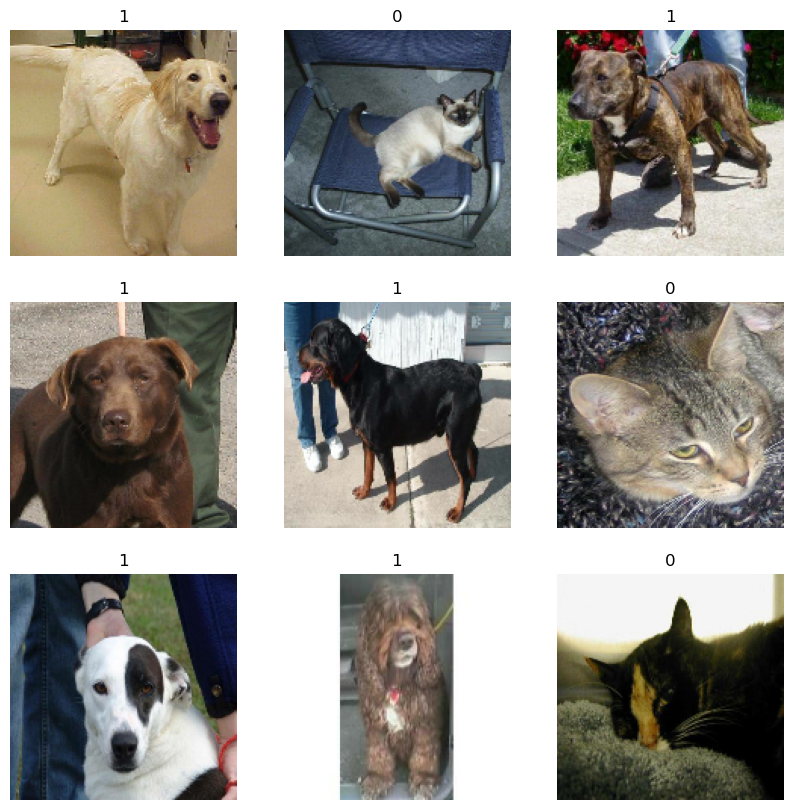

In [4]:
# Show some sample images
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image/255)
    plt.title(int(label))
    plt.axis("off")

# Using random data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.



In [5]:
augmentation_layers = [
    RandomFlip("horizontal"),
    RandomRotation(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

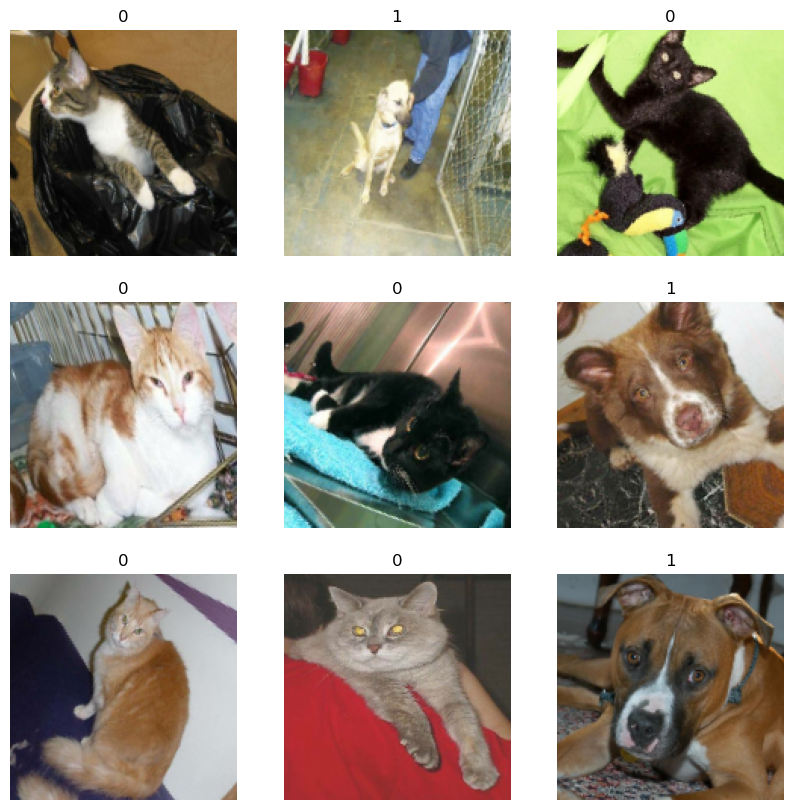

In [6]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image/255)
    plt.title(int(label))
    plt.axis("off")

# show augmentation

tf.Tensor(1, shape=(), dtype=int32)


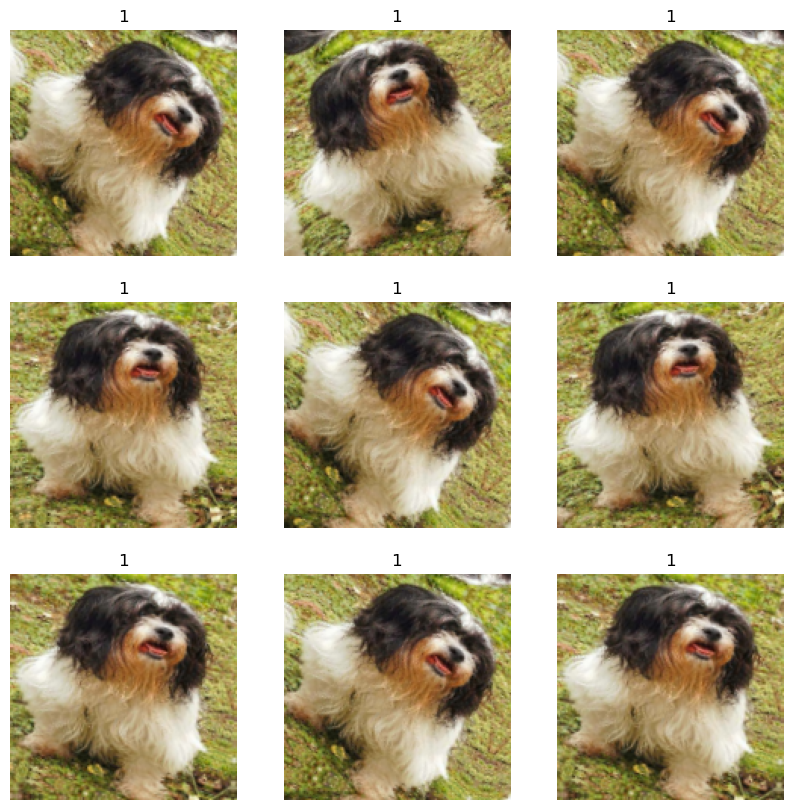

In [7]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images
    print (labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels))
        plt.axis("off")

# Configure batch prefetch

In [8]:
batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

# Build a model
Now let's built a model that follows the blueprint we've explained earlier.

Note that:

* We add a Rescaling layer to scale input values (initially in the [0, 255] range) to the [-1, 1] range.
* We add a Dropout layer before the classification layer, for regularization.
* We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.

In [9]:
base_model = Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False



# Create new model on top
inputs = Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Regularize with dropout
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        20861480  N          
                                                                            
 global_average_pooling2d (G  (None, 2048)             0         Y          
 lobalAveragePooling2D)                                                     
                                                                            
 dropout (Dropout)           (None, 2048)              0         Y          
                                                             

In [10]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(from_logits=True),
    metrics=[BinaryAccuracy()],
)



In [ ]:
epochs = 2
print("Fitting the top layer of the model")
result = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
313/313 [==============================] - 219s 693ms/step - loss: 0.1567 - binary_accuracy: 0.9325 - val_loss: 0.0763 - val_binary_accuracy: 0.9724
Epoch 2/2
194/313 [=================>............] - ETA: 1:11 - loss: 0.1153 - binary_accuracy: 0.9522

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

# Do a round of fine-tuning of the entire model
Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss=BinaryCrossentropy(from_logits=True),
    metrics=[BinaryAccuracy()],
)


In [ ]:

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

After 10 epochs, fine-tuning gains us a nice improvement here. Let's evaluate the model on the test dataset:

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)